# Creating Baseline Models

We've cleaned our data, created some visuals to help gain some insights, and can now move on to creating some baseline models to predict the failure rate.

This notebook is mainly a first pass skim of baselines and is not exhaustive in finding the best possible model for our problem at the moment.

Starting off, we'll import our necessary libraries and data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

The data we'll be using comes from the second notebook titled `02_feature_eng_preprocessing.ipynb`

In [2]:
df = pd.read_csv('../data/processed/model_data.csv')
df.sample(5)

,break_type,break_nature,break_apparent_cause,break_categorization,asset_size,asset_material,num_breaks,age_at_break,positive_pressure_maintaned,air_gap_maintaned,mechanical_removal,flushing_excavation,higher_velocity_flushing,anode_installed,asset_exists,failure_rate
1710,0,4,4,0,150.0,1,3,43,1,1,1,1,1,1,1,0.0698
1871,0,1,2,0,200.0,1,2,52,1,1,1,1,1,1,1,0.0385
1499,0,4,0,0,150.0,1,5,49,1,1,1,1,1,1,1,0.1020
470,0,4,4,0,150.0,1,1,48,1,1,1,1,1,1,1,0.0208
1223,0,4,4,0,150.0,4,2,28,1,1,1,1,1,1,1,0.0714


It would be a good idea to double check that there are no null or missing values

In [3]:
print(df.shape)
df.info()

(2036, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   break_type                   2036 non-null   int64  
 1   break_nature                 2036 non-null   int64  
 2   break_apparent_cause         2036 non-null   int64  
 3   break_categorization         2036 non-null   int64  
 4   asset_size                   2036 non-null   float64
 5   asset_material               2036 non-null   int64  
 6   num_breaks                   2036 non-null   int64  
 7   age_at_break                 2036 non-null   int64  
 8   positive_pressure_maintaned  2036 non-null   int64  
 9   air_gap_maintaned            2036 non-null   int64  
 10  mechanical_removal           2036 non-null   int64  
 11  flushing_excavation          2036 non-null   int64  
 12  higher_velocity_flushing     2036 non-null   int64  
 13  anode_i

In [4]:
df.describe()

,break_type,break_nature,break_apparent_cause,break_categorization,asset_size,asset_material,num_breaks,age_at_break,positive_pressure_maintaned,air_gap_maintaned,mechanical_removal,flushing_excavation,higher_velocity_flushing,anode_installed,asset_exists,failure_rate
count,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.0,2036.000000
mean,0.010314,3.141454,3.396365,0.121807,182.595776,1.976916,3.275049,46.449902,0.998035,0.998035,0.991650,0.992141,0.994106,0.985265,1.0,0.083351
std,0.101059,1.572063,1.347513,0.471180,88.272741,1.582756,2.450089,13.722198,0.044292,0.044292,0.091017,0.088321,0.076564,0.120519,0.0,0.156406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.009300
25%,0.000000,4.000000,4.000000,0.000000,150.000000,1.000000,1.000000,38.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.031200
50%,0.000000,4.000000,4.000000,0.000000,150.000000,1.000000,3.000000,47.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.058250
75%,0.000000,4.000000,4.000000,0.000000,200.000000,4.000000,4.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.100000
max,1.000000,5.000000,6.000000,2.000000,1200.000000,8.000000,12.000000,108.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,5.000000


I had a problem before in another preprocessing step where I ended up with `inf` values in `failure_rate`, so the code commented out below took care of those values.

Looking at the data bove there doesn't seem to be any `inf` values anymore so we are all good on that front for now.

In [6]:
# inf_values = df[df['failure_rate'] == np.inf]
# inf_values

,break_type,break_nature,break_apparent_cause,break_categorization,asset_size,asset_material,num_breaks,age_at_break,positive_pressure_maintaned,air_gap_maintaned,mechanical_removal,flushing_excavation,higher_velocity_flushing,anode_installed,asset_exists,failure_rate


In [9]:
# df = df.drop(inf_values.index, axis=0)
# df.describe()

## Modeling Pipeline

Without messing around too much, I think it's time to jump in to fitting some basic models.

Here's how I'm going to structure the modeling process:
- split data into X and y datasets
- create train and test sets
- make a pipeline for each model with the following contained in it:
    - normalize the data with `StandardScaler()`
    - define a different model in each pipeline
        - we're predicting a numerical value so our problem is a regression type problem 
        - `LinearRegression()`
        - `RandomForestRegressor()`
        - `DecisionTreeRegressor()`
- fit our training data
- output the accuracy of our model

In [7]:
X = df.drop('failure_rate', axis=1)
y = df['failure_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_pipeline = make_pipeline(StandardScaler(), LinearRegression())
linear_pipeline.fit(X_train, y_train)
linear_pipeline.score(X_test, y_test)

0.1831191105233344

In [8]:
forest_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor())
forest_pipeline.fit(X_train, y_train)
forest_pipeline.score(X_test, y_test)

0.9112483319251677

In [9]:
dectree_pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor())
dectree_pipeline.fit(X_train, y_train)
dectree_pipeline.score(X_test, y_test)

0.899888872102407

We can see that we get the best results with our tree-based models, and if we keep re-running these two tree models then we'll get different scores each time. With the scores varying, let's pluck out which features each model thinks is the most important for determining failure rate.

## Feature Importances

To plot the feature importances, we'll create an importance variable and then sort them from highest to lowest values. Using matplotlib, we create a bar plot using the range of features from the training dataset, but only for the 15 numerical values in the data, and input the sorted importances.

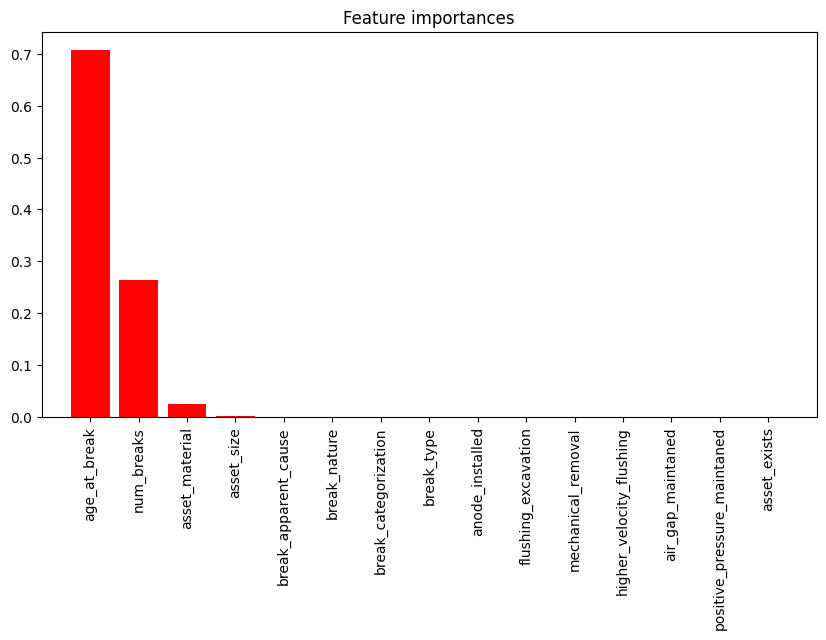

In [10]:
importances = forest_pipeline.steps[1][1].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show();

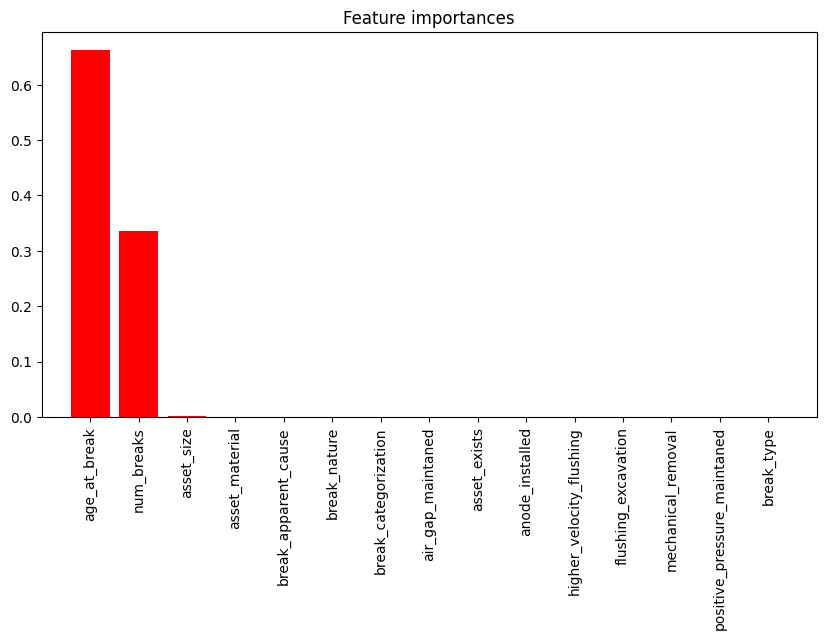

In [11]:
importances = dectree_pipeline.steps[1][1].feature_importances_ 
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show();

In these next steps I'm going to load in a dataset that still has the latitude and longitude data, I'll fit it into a random forest model and then visualize the predictions that we get from it.

In [13]:
final_data = pd.read_csv('../data/interim/final_data.csv')
final_data.sample(5)

,longitude,latitude,incident_date,break_type,break_nature,break_apparent_cause,break_categorization,asset_size,asset_year_installed,asset_material,num_breaks,age_at_break,positive_pressure_maintaned,air_gap_maintaned,mechanical_removal,flushing_excavation,higher_velocity_flushing,anode_installed,asset_exists,failure_rate
1744,-80.505983,43.427656,2019-02-05,0,0,4,0,150.0,1957-01-01,1,2,62,1,1,1,1,1,1,1,0.03
168,-80.447585,43.422057,2003-12-16,0,4,4,0,150.0,1967-01-01,1,4,36,1,1,1,1,1,1,1,0.11
1833,-80.534138,43.441349,2020-06-17,1,5,0,0,13.0,1972-01-01,8,1,48,1,1,0,1,1,1,1,0.02
133,-80.458021,43.453854,2010-01-10,0,0,0,0,150.0,1964-01-01,1,2,46,1,1,1,1,1,1,1,0.04
1266,-80.442459,43.445139,2000-10-07,0,4,4,0,150.0,1965-01-01,1,2,35,1,1,1,1,1,1,1,0.06


In [14]:
final_data[final_data['failure_rate'] == np.inf]

,longitude,latitude,incident_date,break_type,break_nature,break_apparent_cause,break_categorization,asset_size,asset_year_installed,asset_material,num_breaks,age_at_break,positive_pressure_maintaned,air_gap_maintaned,mechanical_removal,flushing_excavation,higher_velocity_flushing,anode_installed,asset_exists,failure_rate
505,-80.492340,43.445806,2011-12-15,0,4,4,0,150.0,2011-01-01,6,1,0,1,1,1,1,1,1,1,inf
886,-80.484931,43.456100,2001-07-03,0,4,4,0,50.0,2001-01-01,6,3,0,1,1,1,1,1,1,1,inf
1014,-80.438473,43.406985,2000-12-11,0,4,4,0,50.0,2000-01-01,6,1,0,1,1,1,1,1,1,1,inf
1077,-80.484936,43.456094,2001-07-06,0,4,4,0,50.0,2001-01-01,6,3,0,1,1,1,1,1,1,1,inf
1118,-80.490677,43.444917,2011-12-15,0,4,4,0,150.0,2011-01-01,6,1,0,1,1,1,1,1,1,1,inf
1378,-80.508320,43.440505,2017-07-24,0,4,4,0,150.0,2017-01-01,7,1,0,1,1,1,1,1,0,1,inf


In [15]:
inf_values = final_data[final_data['failure_rate'] == np.inf]
final_data = final_data.drop(inf_values.index, axis=0)

In [16]:
final_data.drop(['incident_date', 'asset_year_installed'], axis=1, inplace=True)

In [17]:
final_X = final_data.drop('failure_rate', axis=1)
final_y = final_data['failure_rate']

X_train, X_test, y_train, y_test = train_test_split(final_X, final_y, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8746355011360836

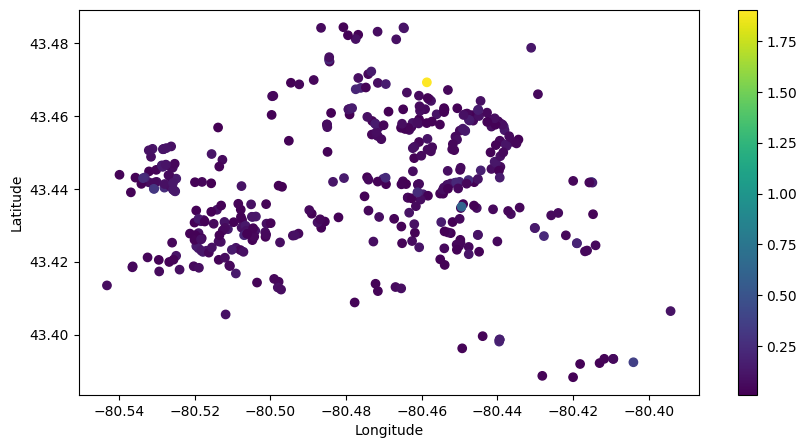

In [25]:
y_pred = rf.predict(X_test)

# save the predictions to a csv file
predictions = pd.DataFrame(y_pred, columns=['predictions'])
predictions.to_csv('../data/processed/predictions.csv', index=False)

# add the predictions to the test data and save it as a new csv file
X_test['predictions'] = y_pred
X_test.to_csv('../data/processed/test_predict_data.csv', index=False)

plt.figure(figsize=(10, 5))
plt.scatter(X_test['longitude'], X_test['latitude'], c=y_pred, cmap='viridis')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

In [19]:
import config
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [20]:
px.set_mapbox_access_token(config.token)
token = config.token
fig = px.scatter_mapbox(data_frame=X_test, lat='latitude', lon='longitude',
                        color='age_at_break', size=y_pred.round(2), hover_name=y_pred.round(2),
                        color_continuous_scale=px.colors.cyclical.IceFire)
fig.update_layout(mapbox_style='carto-positron', mapbox_accesstoken=token)
fig.show(renderer='notebook_connected')

In [21]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key=config.gmaps_api_key)

In [22]:
lat = X_test['latitude'].values
lon = X_test['longitude'].values
break_locations = list(zip(lat, lon))
fig = gmaps.figure()
# fig.add_layer(gmaps.heatmap_layer(break_locations, weights=y_pred))
break_map = gmaps.heatmap_layer(break_locations, weights=y_pred)
fig.add_layer(break_map)
fig

Figure(layout=FigureLayout(height='420px'))

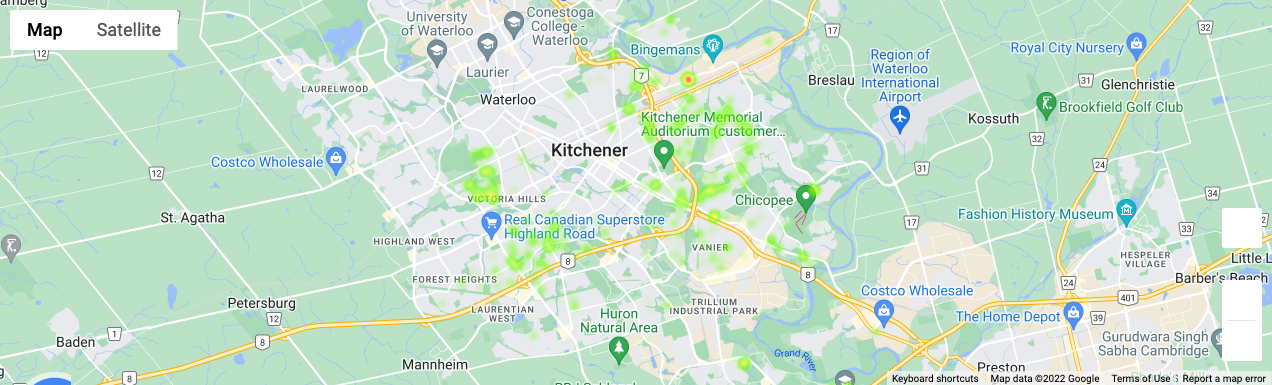

In [24]:
from IPython.display import Image
Image(filename='../figures/predictions_map.png')